<a href="https://colab.research.google.com/github/DhyeyShah794/poetry-analysis/blob/master/poetry_sentiment_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn sentence-transformers sentence-transformers

In [ ]:
!pip install git+https://github.com/cleanlab/cleanlab.git

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from ast import literal_eval
from sentence_transformers import SentenceTransformer, util
import itertools
from collections import Counter
from cleanlab import Datalab
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/DhyeyShah794/poetry-analysis/master/data.csv')

# Basic data exploration and cleaning

In [5]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']


In [6]:
data.describe()

,url,title,poem,categories
count,63731,63158,63400,63731
unique,63731,58548,63205,25106
top,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,Graduation,I remember\nIt was the year\nThe grizzlies ran...,[]
freq,1,72,8,917


In [7]:
data.isnull().sum()

url             0
title         573
poem          331
categories      0
dtype: int64

In [8]:
# Remove those rows where the poem is empty or category values is an empty list
# Poems with no titles can also be used for analysis
data = data[data['poem'].notnull()]
data = data[~data['categories'].isin(['[]'])]

In [9]:
data.describe()

,url,title,poem,categories
count,62524,62003,62524,62524
unique,62524,57607,62330,25036
top,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,Home,I remember\nIt was the year\nThe grizzlies ran...,['women']
freq,1,39,8,357


In [10]:
data.isnull().sum()  # Check if null values have been removed

url             0
title         521
poem            0
categories      0
dtype: int64

In [11]:
# Messy data instances
# data[data['url'].str.contains('Betweenkittensandriots')]

In [12]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']


In [13]:
# Convert category values from str to list
data['categories'] = data['categories'].apply(literal_eval)

# Transform the values to a comma-separated string
# (eg. from "['haiku', 'acrostic', 'humor']" to "haiku,acrostic,humor")
data['categories'] = data['categories'].apply(lambda x: ','.join(x))

In [14]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,acrostic
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"haiku,acrostic,humor"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,acrostic
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"haiku,acrostic"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,acrostic


In [31]:
# First split each category by comma in the list comprehension
# Create a flattened list of all categories (generator technically)
# Passing it to the Counter method returns a Counter object with category names as keys and their corresponding frequencies as values
cat_freq = Counter(itertools.chain.from_iterable(cat_val.split(',') for cat_val in data['categories']))

unique_cats = sorted((set(cat_freq.keys())))  # For later use

In [32]:
n = 25
total_count = sum(cat_freq.values())

# Convert Counter object to a list to allow slicing
cat_freq = list(cat_freq.most_common())

# The first n and last n (reversed) elements are the n most frequent and n least frequent respectively
most_freq, least_freq = cat_freq[:n], cat_freq[-n:][::-1]

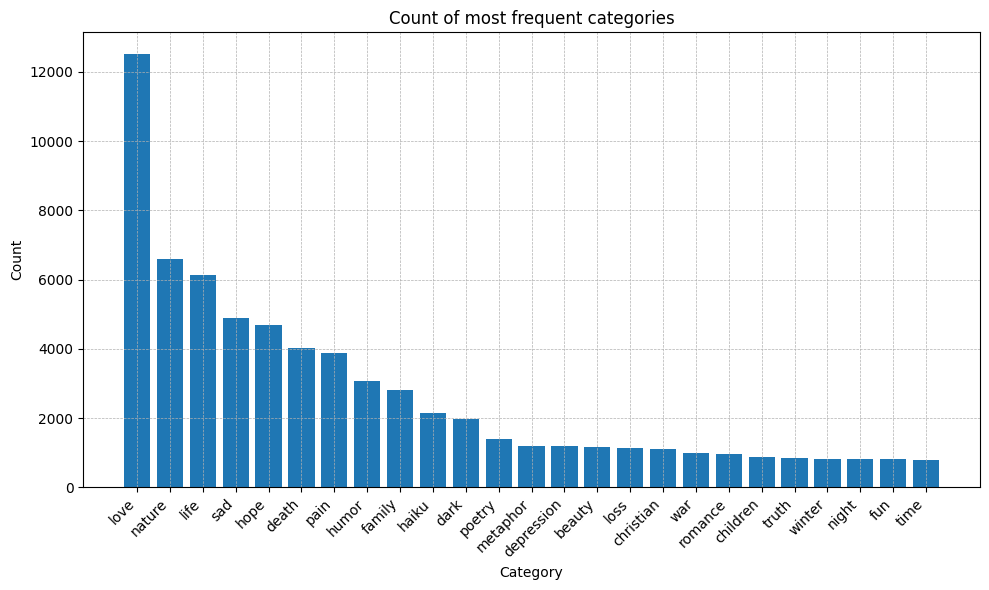

In [33]:
# Count of most frequent categories

cats, counts = zip(*most_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of most frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

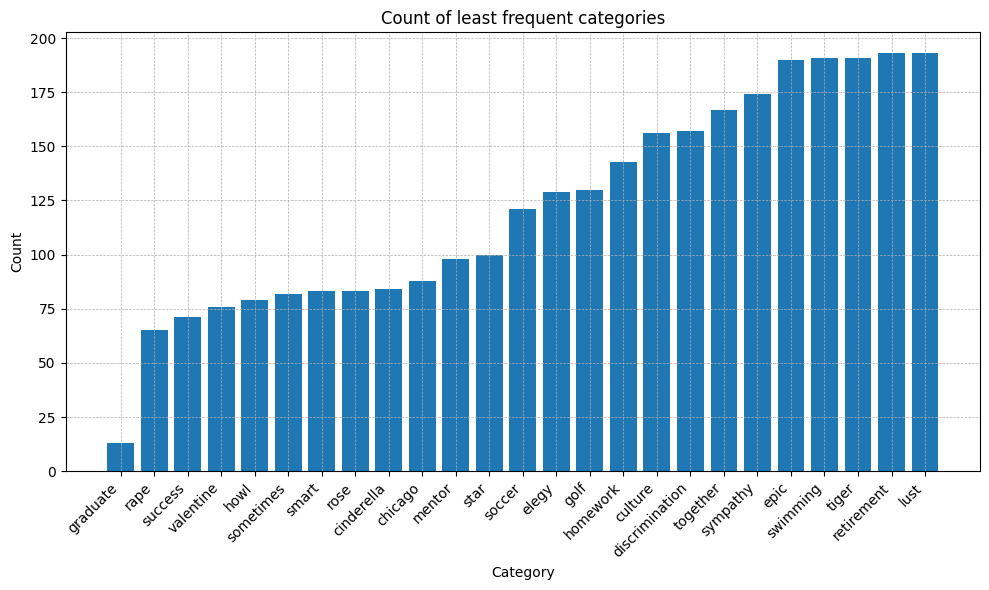

In [18]:
# Count of least frequent categories

cats, counts = zip(*least_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of least frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of Poem Lengths')

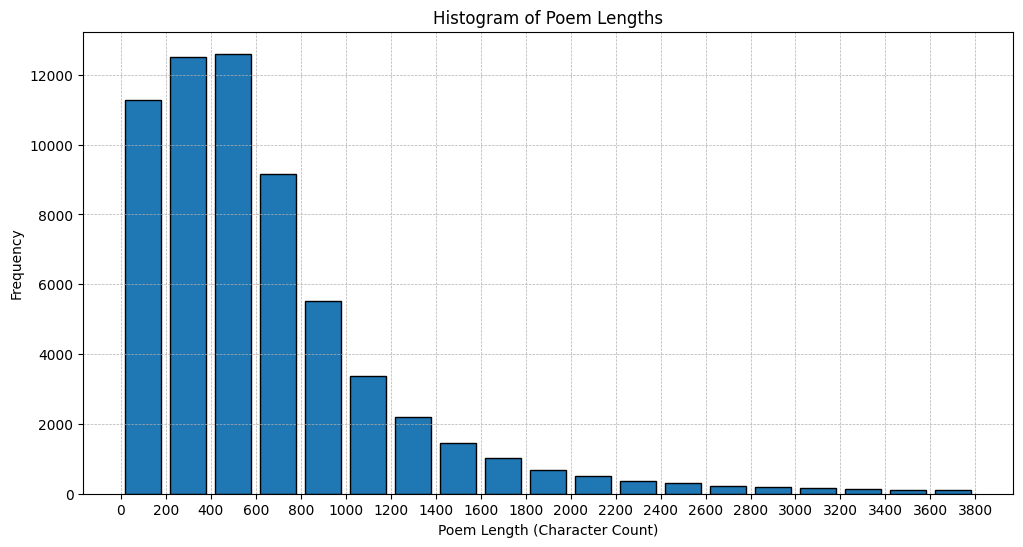

In [19]:
data['poem_length'] = data['poem'].apply(len)
intervals = [i * 200 for i in range(20)]

plt.figure(figsize=(12, 6))
plt.hist(data['poem_length'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(intervals)

plt.xlabel('Poem Length (Character Count)')
plt.ylabel('Frequency')
plt.title('Histogram of Poem Lengths')

In [20]:
def word_count(text):
  words = re.findall(r'\w+', text)
  return len(words)

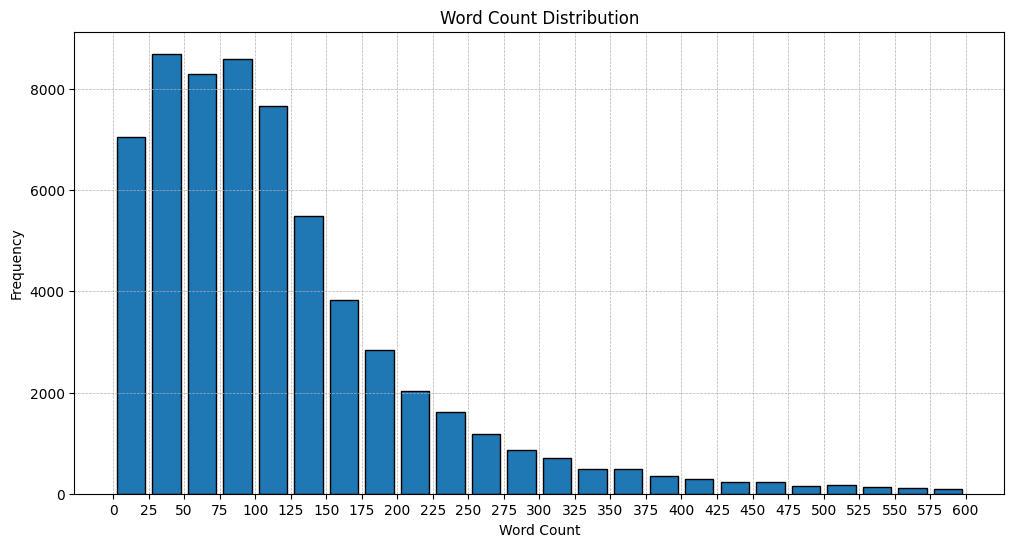

In [22]:
data['word_count'] = data['poem'].apply(word_count)
intervals = [i * 25 for i in range (25)]

plt.figure(figsize=(12, 6))
plt.hist(data['word_count'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.xticks(intervals)

plt.show()

# Combining semantically similar categories

In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
pairs = list(itertools.combinations(unique_cats, 2))
cosine_scores = []
for pair in pairs:
  cat1 = pair[0]
  cat2 = pair[1]
  embeddings1 = model.encode(cat1)
  embeddings2 = model.encode(cat2)
  cosine_score = util.cos_sim(embeddings1, embeddings2)
  cosine_scores.append(cosine_score.item())

In [ ]:
cosine_scores

In [ ]:
threshold = 0.7
new = [(i, cosine_scores[i]) for i in range(len(cosine_scores)) if cosine_scores[i] >= threshold]

In [ ]:
similar_pairs = [pairs[value[0]] for value in new]
print(similar_pairs)

[('animal', 'dog'), ('april', 'august'), ('april', 'january'), ('august', 'july'), ('august', 'october'), ('beach', 'ocean'), ('child', 'children'), ('child', 'daughter'), ('death', 'murder'), ('death', 'suicide'), ('education', 'school'), ('father', 'mother'), ('fish', 'fishing'), ('football', 'soccer'), ('graduate', 'graduation'), ('home', 'house'), ('humor', 'laughter'), ('husband', 'marriage'), ('july', 'june'), ('july', 'october'), ('marriage', 'wedding'), ('mom', 'mother'), ('ocean', 'sea'), ('october', 'september'), ('pink', 'purple'), ('poem', 'poetry'), ('romance', 'romantic'), ('snow', 'winter'), ('spring', 'summer'), ('sun', 'sunset'), ('sun', 'sunshine'), ('sunset', 'sunshine'), ('woman', 'women')]


In [ ]:
with open('similar_pairs.txt', 'w') as f:
  for pair in similar_pairs:
    f.write(f'{pair[0]}, {pair[1]}\n')

In [ ]:
# Categories to be combined

# Experimenting with cleanlab

In [23]:
new = data.copy()
new.drop(new.index[-60_000:], inplace=True)
new.shape

(2524, 6)

In [40]:
raw_texts, labels, urls = new["poem"].values, new["categories"].values, new["url"].values
num_classes = len(set(labels))

print(f"This dataset has {num_classes} classes.")
print(f"Classes: {set(labels)}")

This dataset has 1192 classes.
Classes: {'africa,cat', 'lonely,alone,travel', 'alone,loss,heart', 'ode,angel,love', 'anger,sad,grief,death', 'animal,haiku', 'humor,anniversary', 'dark,america,metaphor', 'despair,anger,pain,grief', 'tiger,animal', 'dark,heaven,death,angel', 'america,war,racism', 'poetry,acrostic,beauty', 'alone,family', 'anger,nature', 'school,america,death', 'food,animal', 'love,peace,africa,freedom', 'education,dark,america,money', 'america,racism,death', 'fairy,angel', 'acrostic,nature', 'depression,fear,anger,hate,love', 'animal,happy,nature', 'anger,pain,greed,power,women', 'ocean,nature,love,animal', 'life,anger,pain', 'death,angel,war', 'angel,pain,joy,heart,love', 'africa,culture', 'africa,war,death', 'lonely,acrostic,alone', 'sad,life,pain,acrostic,family', 'lonely,alone,sad', 'travel,america,city', 'education,america,truth', 'pain,sad,animal,family,love', 'humor,america,love', 'america,money,truth', 'dark,angel,pain', 'hope,love,family,animal', 'sad,death,anim

In [26]:
transformer = SentenceTransformer('google/electra-small-discriminator')
text_embeddings = transformer.encode(raw_texts)

In [27]:
model = LogisticRegression(max_iter=400)

pred_probs = cross_val_predict(model, text_embeddings, labels, method="predict_proba")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1116: RuntimeWarning: Number of classes in training fold (1004) does not match total number of classes (1192). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in

In [28]:
data_dict = {"texts": raw_texts, "labels": labels}

In [29]:
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=text_embeddings)

Finding label issues ...


/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 1, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 2, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 3, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 4, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 5, it has too few examples (see `min_examples_per_class` argument)
  warnings.w

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...

Audit complete. 514 issues found in the dataset.


In [30]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

     issue_type  num_issues
          label         364
        outlier         130
 near_duplicate          19
        non_iid           1
class_imbalance           0

Dataset Information: num_examples: 2524, num_classes: 1192


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 364
Overall dataset quality in terms of this issue: 0.1387

Examples representing most severe instances of this issue:
      is_label_issue  label_score                                 given_label predicted_label
1261           False          0.0                                america,hate          animal
873            False          0.0                        alone,loss,time,love          africa
1718           False          0.0  b

In [41]:
for i in [1619, 1668, 2333, 2337, 2255, 2398]:
  print(f"URL: {urls[i]}")
  print(f"Category: {labels[i]}")
  print(f"Poem: {raw_texts[i][:50]}")

URL: https://allpoetry.com/poem/16395872-An-Angel-Can-Fall-From-Above-by-Katrine-K%C3%A6rsvang
Category: christian,angel,pain,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16161285-An-angel-can-fall-from-above-by-AngelicKatrine
Category: god,angel,sad,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16831008-The-stones-are-my-mind-by-Eyewind--by-Eyewind
Category: metaphor,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/16824865-The-stones-are-my-mind-by-Eyewind-by-Eyewind
Category: metaphor,fire,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/14244434-A-Native-of-Florida-s-Reefs----Fishing--by-Dr.Ram-Mehta
Category: animal
Poem: I am the native of the Florida Keys and Bahamas
Pe
URL: https://allpoetry.com/poem/16667594-A-Native-of-Florida-s-Reefs----Animal--by-Dr.Ram-Mehta
Category: animal
Poem: I am